# 1. Mengimpor Library

---

Pada bab ini, kita akan mengimpor berbagai library yang diperlukan untuk analisis data dan pembuatan model. Library yang digunakan antara lain `pandas` untuk manipulasi data, `numpy` untuk operasi numerik, `seaborn` dan `matplotlib` untuk visualisasi data, serta `tensorflow` dan `keras` untuk pembuatan model machine learning. Selain itu, kita juga akan menggunakan `sklearn` untuk ekstraksi fitur dan pengukuran kesamaan.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-01-04 13:23:39.088215: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-04 13:23:39.103793: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-04 13:23:39.156438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-04 13:23:39.236436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-04 13:23:39.242770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 13:23:39.259103: I tensorflow/core/platform/cpu_feature_gu

# 2. Data Loading

---

Data yang digunakan dalam proyek ini diambil dari [Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database/data) yang tersedia di Kaggle. Dataset ini terdiri dari dua file utama: `anime.csv` yang berisi informasi tentang berbagai anime, dan `rating.csv` yang berisi rating yang diberikan oleh pengguna untuk setiap anime.

In [ ]:
df_anime = pd.read_csv("data/anime.csv")
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
df_rating = pd.read_csv("data/rating.csv")
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# 3. Data Understanding

---

Dataset ini berisi informasi tentang preferensi pengguna dari 73.516 pengguna pada 12.294 anime. Setiap pengguna dapat menambahkan anime ke daftar yang telah mereka selesaikan dan memberikan rating, dan dataset ini merupakan kompilasi dari rating tersebut. Sumber dataset ini dapat ditemukan di [Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database/data).

## 3.1. Melihat ukuran data

In [63]:
anime_rows, anime_cols = df_anime.shape
rating_rows, rating_cols = df_rating.shape

print(f"Jumlah baris data anime: {anime_rows}")
print(f"Jumlah kolom data anime: {anime_cols}")
print()
print(f"Jumlah baris data rating: {rating_rows}")
print(f"Jumlah kolom data rating: {rating_cols}")

Jumlah baris data anime: 12294
Jumlah kolom data anime: 7

Jumlah baris data rating: 7813737
Jumlah kolom data rating: 3


Dataset `anime.csv` memiliki jumlah baris sebanyak **12.294** dan jumlah kolom sebanyak **7**. Ini menunjukkan bahwa terdapat 12.294 entri anime yang berbeda dengan 7 atribut yang mendeskripsikan setiap anime tersebut. Sementara itu, dataset `rating.csv` memiliki jumlah baris sebanyak **7.813.737** dan jumlah kolom sebanyak **3**. Berikut adalah penjelasan dari masing-masing kolom pada kedua dataset tersebut:

**anime.csv**

- anime_id : id unik myanimelist.net yang mengidentifikasi sebuah anime.
- name : nama lengkap anime.
- genre : daftar genre yang dipisahkan dengan koma untuk anime ini.
- type : film, TV, OVA, dll.
- episodes : berapa banyak episode dalam anime ini. (1 jika film).
- rating : rata-rata rating dari 10 untuk anime ini.
- members : jumlah anggota komunitas yang ada dalam "grup" anime ini.

**rating.csv**

- user_id : id unik myanimelist.net yang mengidentifikasi seorang pengguna.
- anime_id : anime yang telah dinilai oleh pengguna ini.
- rating : rating dari 10 yang diberikan pengguna ini (-1 jika pengguna menontonnya tetapi tidak memberikan rating).


## 3.2. Jumlah Data Unik

In [8]:
unique_anime_ids = df_anime['anime_id'].nunique()
unique_user_ids = df_rating['user_id'].nunique()

print(f"Jumlah data anime ID: {unique_anime_ids}")
print(f"Jumlah data user ID: {unique_user_ids}")

Jumlah data anime ID: 12294
Jumlah data user ID: 73515


Berdasarkan hasil perhitungan, terdapat sebanyak **12.294** data anime unik yang tersedia dalam dataset `anime.csv`. Selain itu, terdapat sebanyak **73.515** pengguna unik yang memberikan rating pada berbagai anime dalam dataset `rating.csv`.

## 3.3. Informasi Data

In [16]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Pada dataset `anime.csv`, terdapat beberapa kolom yang memiliki tipe data yang berbeda. Kolom `anime_id` dan `members` memiliki tipe data integer, kolom `name`, `genre`,  `type`, dan `episodes` memiliki tipe data string, sedangkan kolom `rating` memiliki tipe data float.

In [17]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Sementara itu, pada dataset `rating.csv`, semua kolom memiliki tipe data integer.

## 3.4. Statistik Deskriptif

In [18]:
df_anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Deskripsi statistik dari dataset `anime.csv` menunjukkan bahwa rata-rata rating anime adalah sebesar 6.47, dengan rating terendah sebesar 1.67 dan rating tertinggi sebesar 10. Sementara itu, anime dengan jumlah anggota terendah memiliki 5 anggota, sedangkan anime dengan jumlah anggota terbanyak memiliki 1.013.917 anggota.

In [19]:
df_rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Deskripsi statistik dari dataset `rating.csv` menunjukkan bahwa rata-rata rating yang diberikan oleh pengguna adalah sebesar 6.14, dengan rating terendah sebesar -1 dan rating tertinggi sebesar 10.

## 3.5. Univariate Exploratory Data Analysis (EDA)

Univariate Exploratory Data Analysis (EDA) adalah proses analisis data yang berfokus pada satu variabel pada satu waktu. Tujuan utama dari univariate EDA adalah untuk memahami karakteristik dasar dari variabel tersebut, seperti distribusi, pusat data, dan penyebaran data.

### 3.5.1. Dataset `anime.csv`

#### Top Anime Berdasarkan Jumlah Anggota

/tmp/ipykernel_259915/4171300265.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='members', data=top_anime, palette='viridis')


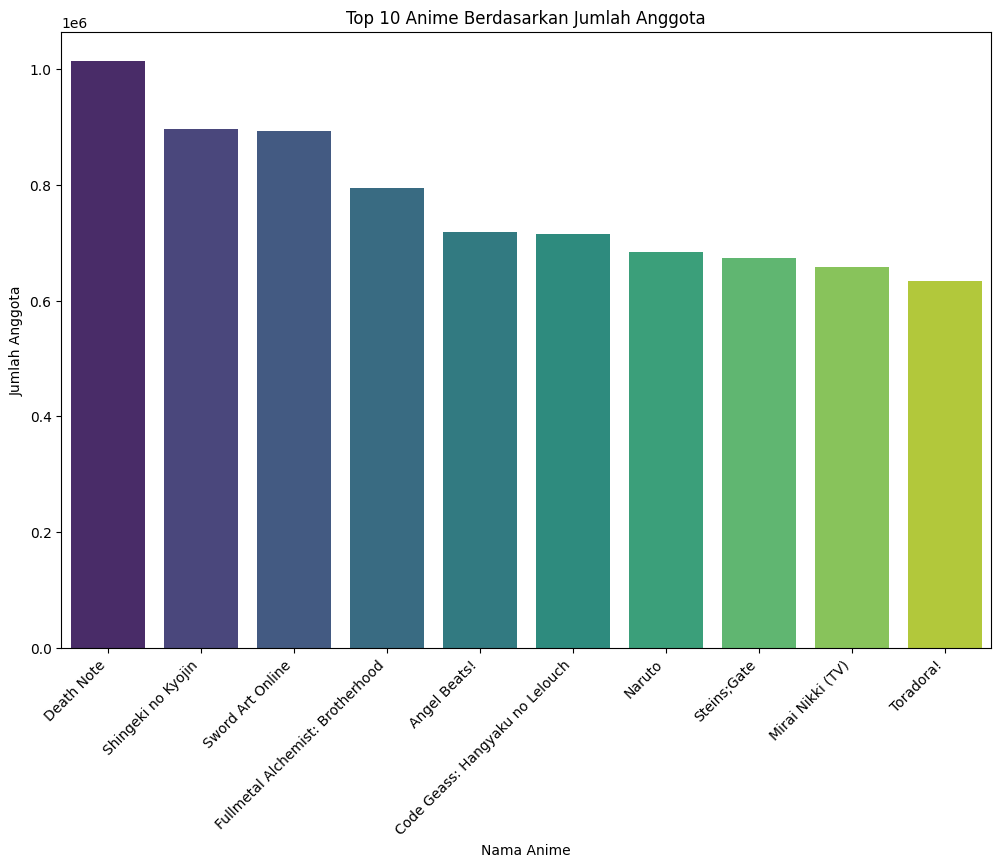

In [34]:
# Select top 10 anime based on the number of members
top_anime = df_anime.nlargest(10, 'members')

# Create a vertical bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='name', y='members', data=top_anime, palette='viridis')
plt.title('Top 10 Anime Berdasarkan Jumlah Anggota')
plt.xlabel('Nama Anime')
plt.ylabel('Jumlah Anggota')
plt.xticks(rotation=45, ha='right')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa anime dengan jumlah anggota terbanyak adalah anime dengan judul "Death Note" yang memiliki lebih dari 1 juta anggota, diikuti oleh anime "Shingeki no Kyojin" dan "Sword Art Online".

#### Distribusi Tipe Anime

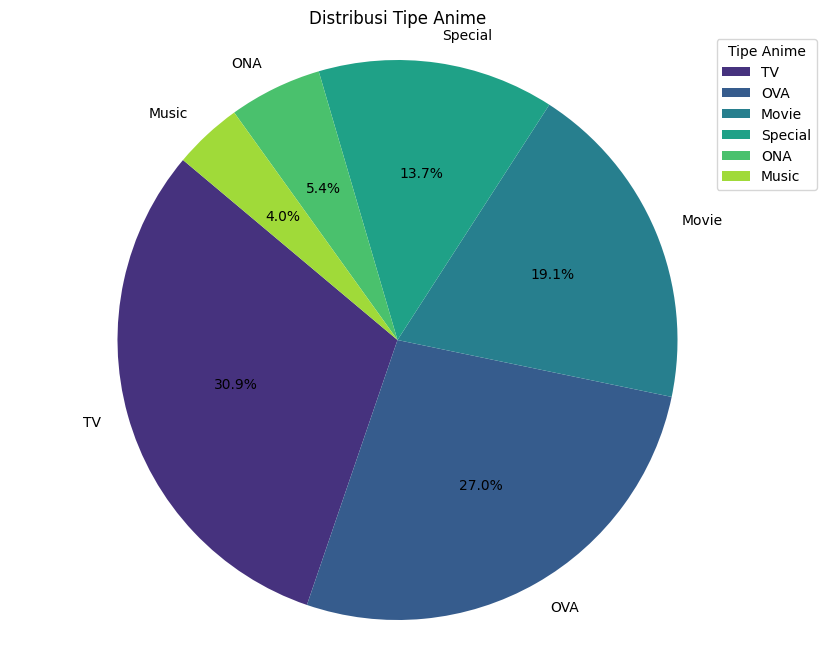

In [27]:
# Menghitung distribusi tipe anime
type_counts = df_anime['type'].value_counts()

# Membuat pie chart
plt.figure(figsize=(10, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(type_counts)))
plt.title('Distribusi Tipe Anime')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(type_counts.index, title="Tipe Anime", bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa anime dengan tipe `TV` adalah yang paling banyak, diikuti oleh anime dengan tipe `OVA`, `Movie`, `Special`, `ONA`, dan `Music` sebagai tipe anime yang paling sedikit.

#### Distribusi Genre Anime

/tmp/ipykernel_259915/2182531986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


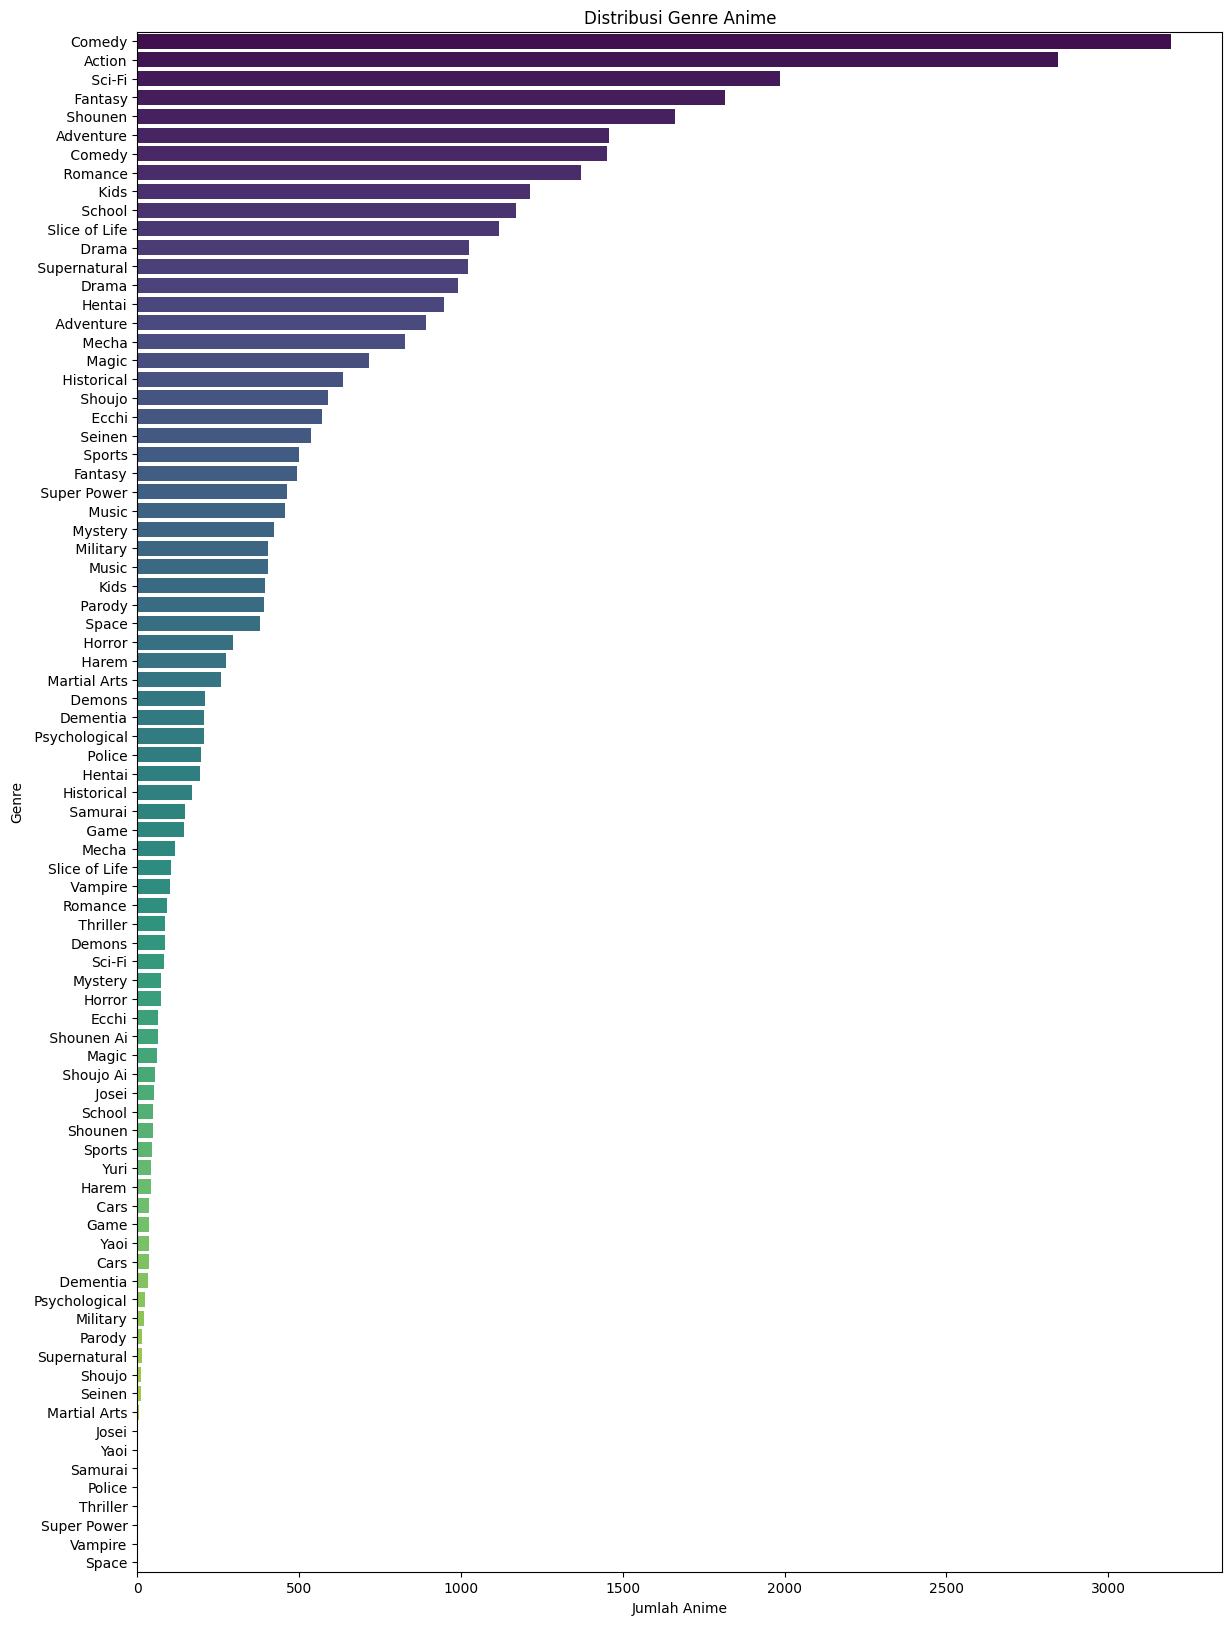

In [33]:
# Menghitung distribusi genre anime
genre_counts = df_anime['genre'].str.split(',').explode().value_counts()

# Create a bar plot for the distribution of anime genres
plt.figure(figsize=(14, 20))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribusi Genre Anime')
plt.xlabel('Jumlah Anime')
plt.ylabel('Genre')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa genre `Comey` adalah genre yang paling banyak, diikuti oleh genre `Action`, `Sci-Fi`, `Fantasy`, dan `Shounen`.

#### Distribusi Rating Anime

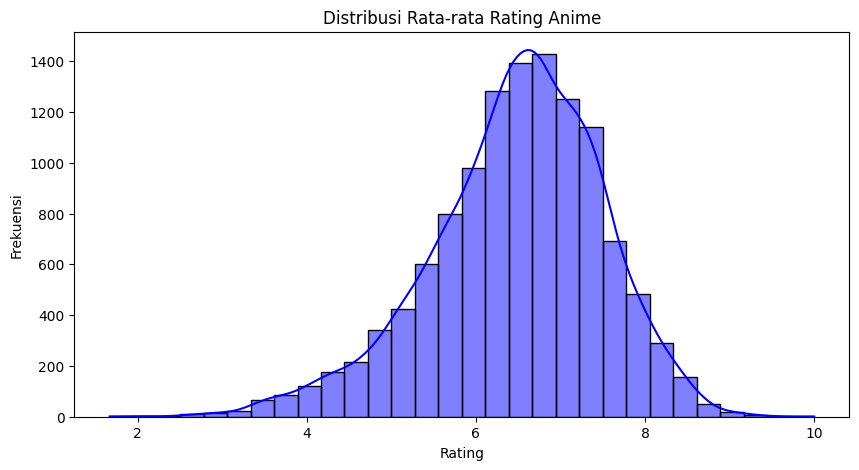

In [39]:
# Create a histogram for the distribution of average anime ratings
plt.figure(figsize=(10, 5))
sns.histplot(df_anime['rating'].dropna(), bins=30, kde=True, color='blue')
plt.title('Distribusi Rata-rata Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Distribusi rating anime sebagian besar tersebar antara `5.5` hingga `8.0`. Hal ini menunjukkan bahwa mayoritas anime memiliki rating yang cukup baik, dengan sedikit anime yang memiliki rating sangat rendah atau sangat tinggi. Distribusi ini cenderung **left-skewed**, yang berarti lebih banyak anime yang memiliki rating di atas rata-rata dibandingkan dengan yang memiliki rating di bawah rata-rata. Skewness ini menunjukkan bahwa penonton cenderung memberikan rating yang lebih tinggi untuk anime yang mereka tonton.

### 3.5.2. Dataset `rating.csv`

In [41]:
df_rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


#### Pengguna dengan Rating Terbanyak

In [46]:
# Group by user_id and count the number of ratings for each user
user_rating_counts = df_rating.groupby('user_id').size().reset_index(name='rating_count')

# Find the user with the most ratings
top_user = user_rating_counts.nlargest(10, 'rating_count')

# Reset the index of the result DataFrame
top_user.reset_index(drop=True, inplace=True)

# Return the result as a DataFrame
top_user

,user_id,rating_count
0,48766,10227
1,42635,3747
2,53698,2905
3,57620,2702
4,59643,2633
5,51693,2622
6,27364,2499
7,45659,2469
8,7345,2429
9,66021,2362


Dari tabel di atas, kita dapat melihat bahwa pengguna dengan id `48766` memberikan rating terbanyak, yaitu sebanyak `10.227` anime.

#### Distribusi Rating Pengguna

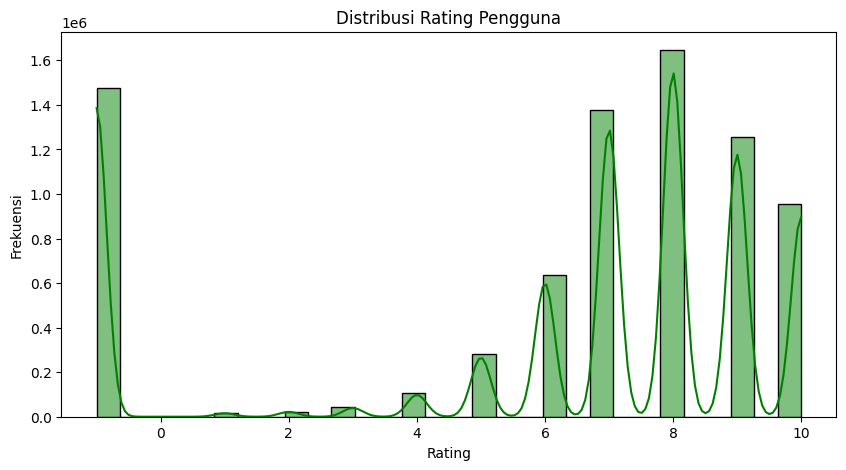

In [42]:
# Create a histogram for the distribution of user ratings
plt.figure(figsize=(10, 5))
sns.histplot(df_rating['rating'], bins=30, kde=True, color='green')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa sebagian besar pengguna memberikan rating antara `6` hingga `10`. Hal ini menunjukkan bahwa mayoritas pengguna memberikan rating yang cukup baik untuk anime yang mereka tonton. Selain itu, terdapat sejumlah pengguna yang memiliki rating `-1`, hal menunjukkan bahwa mereka menonton anime tersebut tetapi tidak memberikan rating. Data rating `-1` ini kemungkinan besar akan dihapus karena tidak memberikan informasi yang berguna dalam pembuatan model rekomendasi.

# 4. Data Preparation

---

Pada tahap ini, kita akan melakukan beberapa langkah pre-processing data untuk mempersiapkan data sebelum digunakan dalam pembuatan model rekomendasi. Langkah-langkah pre-processing yang akan dilakukan antara lain adalah menghapus data yang tidak relevan, menangani missing values, dan menangani data yang duplikat.

## 4.1. Filter Pengguna dengan Rating Sebanyak 1000 atau Lebih

In [105]:
df_rating.shape

(7813737, 3)

In [123]:
# Group by user_id and count the number of rated anime for each user
user_rating_counts = df_rating.groupby('user_id').size().reset_index(name='anime_count')

# Sort the result by anime_count in descending order
user_rating_counts = user_rating_counts.sort_values(by='anime_count', ascending=False)

# Display the result
user_rating_counts

,user_id,anime_count
48764,48766,10227
42634,42635,3747
53696,53698,2905
57618,57620,2702
59641,59643,2633
...,...,...
11322,11323,1
48773,48775,1
11327,11328,1
48741,48743,1


In [124]:
# Menghitung jumlah pengguna dengan anime_count >= 500
users_with_500_or_more = user_rating_counts[user_rating_counts['anime_count'] >= 500].shape[0]

# Menghitung jumlah pengguna dengan anime_count < 500
users_with_less_than_500 = user_rating_counts[user_rating_counts['anime_count'] < 500].shape[0]

print(f"Jumlah pengguna dengan anime_count >= 500: {users_with_500_or_more}")
print(f"Jumlah pengguna dengan anime_count < 500: {users_with_less_than_500}")

Jumlah pengguna dengan anime_count >= 500: 1853
Jumlah pengguna dengan anime_count < 500: 71662


In [125]:
filtered_users = user_rating_counts[user_rating_counts['anime_count'] >= 500]

# Filter df_rating to include only users with anime_count >= 500
df_rating = df_rating[df_rating['user_id'].isin(filtered_users['user_id'])]

# Display the shape of the filtered dataframe
df_rating

,user_id,anime_id,rating
1614,17,6,7
1615,17,19,10
1616,17,30,9
1617,17,32,10
1618,17,43,8
...,...,...,...
7812698,73502,18893,9
7812699,73502,19151,5
7812700,73502,19221,6
7812701,73502,19367,6


## 4.2. Menghapus Data yang Tidak Relevan

Pada dataset `rating.csv`, terdapat beberapa anime yang memiliki rating `-1`. Data ini akan dihapus karena tidak memberikan informasi yang berguna dalam pembuatan model rekomendasi.

In [17]:
df_anime.head(1)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630


In [18]:
df_rating.head(1)

,user_id,anime_id,rating
29646,342,1,-1


In [126]:
# Melihat value count dari rating user
df_rating['rating'].value_counts()

rating
-1     289627
 8     281036
 7     280571
 9     162049
 6     151486
 10     99668
 5      71751
 4      26542
 3      11488
 2       6197
 1       4216
Name: count, dtype: int64

Terdapat sebanyak `1.476.496` data rating yang memiliki rating `-1`. Data ini akan dihapus dari dataframe `df_rating`.

In [127]:
df_rating = df_rating[df_rating['rating'] != -1]

# Melihat value count dari rating user
df_rating['rating'].value_counts()

rating
8     281036
7     280571
9     162049
6     151486
10     99668
5      71751
4      26542
3      11488
2       6197
1       4216
Name: count, dtype: int64

Terlihat bahwa rating `-1` telah dihapus dari dataframe `df_rating`.

In [112]:
df_rating.shape

(4927724, 3)

## 4.4. Menangani Data Duplikat

In [162]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_anime[df_anime.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows in anime dataframe: {duplicate_rows.shape[0]}")

Number of duplicate rows in anime dataframe: 0


In [163]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_rating[df_rating.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows in rating dataframe: {duplicate_rows.shape[0]}")

Number of duplicate rows in rating dataframe: 0


# 5. Data Modeling

## 5.1. Content-based Filtering

In [25]:
# Drop rows with missing values in the 'genre' column
anime = df_anime.dropna(subset=['genre'])

In [31]:
# Create a TF-IDF Vectorizer to transform the 'genre' column
tfidf = TfidfVectorizer()

In [32]:
# Fit and transform the 'genre' column
tfidf_matrix = tfidf.fit_transform(anime['genre'])

In [33]:
# Compute the cosine similarity matrix
features = tfidf.get_feature_names_out()
features

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

In [34]:
# Mengubah matriks TF-IDF menjadi dense array
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29450574, 0.31749916, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25046406, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
pd.DataFrame(tfidf_matrix.toarray(), columns=features, index=anime['name'])

,action,adventure,ai,arts,cars,comedy,dementia,demons,drama,ecchi,...,shounen,slice,space,sports,super,supernatural,thriller,vampire,yaoi,yuri
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.440150,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.544484,0.000000,0.0,0.0,0.0
Fullmetal Alchemist: Brotherhood,0.294506,0.317499,0.0,0.0,0.0,0.000000,0.0,0.0,0.335755,0.0,...,0.350932,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
Gintama°,0.250464,0.000000,0.0,0.0,0.0,0.200529,0.0,0.0,0.000000,0.0,...,0.298452,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
Steins;Gate,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.834015,0.0,0.0,0.0
Gintama&#039;,0.250464,0.000000,0.0,0.0,0.0,0.200529,0.0,0.0,0.000000,0.0,...,0.298452,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover: Minami tai Mecha-Minami,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
Under World,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
Violence Gekiga David no Hoshi,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [37]:
# Menghitung cosine similarity dari matriks TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14778251, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14778251, 1.        , 0.17849957, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17849957, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [38]:
df_cosine_sim = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])
df_cosine_sim

name,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood,Gintama°,Steins;Gate,Gintama&#039;,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,Gintama&#039;: Enchousen,...,Super Erotic Anime,Taimanin Asagi 3,Teleclub no Himitsu,Tenshi no Habataki Jun,The Satisfaction,Toushindai My Lover: Minami tai Mecha-Minami,Under World,Violence Gekiga David no Hoshi,Violence Gekiga Shin David no Hoshi: Inma Densetsu,Yasuji no Pornorama: Yacchimae!!
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,1.000000,0.147783,0.000000,0.000000,0.000000,0.424942,0.000000,0.156427,0.000000,0.000000,...,0.0,0.279199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fullmetal Alchemist: Brotherhood,0.147783,1.000000,0.178500,0.000000,0.178500,0.283764,0.340307,0.407484,0.178500,0.178500,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama°,0.000000,0.178500,1.000000,0.220705,1.000000,0.182876,0.195514,0.199153,1.000000,1.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Steins;Gate,0.000000,0.000000,0.220705,1.000000,0.220705,0.000000,0.000000,0.274693,0.220705,0.220705,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gintama&#039;,0.000000,0.178500,1.000000,0.220705,1.000000,0.182876,0.195514,0.199153,1.000000,1.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover: Minami tai Mecha-Minami,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.498654,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Under World,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.498654,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Violence Gekiga David no Hoshi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.498654,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
df_cosine_sim.shape

(12232, 12232)

In [47]:
# Function to get recommendations based on the cosine similarity score
def get_recommendations(title, cosine_sim, anime, n=10):
    # Get the index of the anime that matches the title
    idx = anime[anime['name'] == title].index[0]

    # Get the pairwise similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top n most similar anime
    sim_scores = sim_scores[1:n+1]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top n most similar anime
    return anime.iloc[anime_indices][['anime_id', 'name', 'genre', 'rating', 'members']]

In [192]:
# Get a random anime title from the dataset
random_title = random.choice(anime['name'].tolist())
# Print the random anime title and its genre
random_genre = anime[anime['name'] == random_title]['genre'].values[0]
print(f"Random anime title: {random_title}")
print(f"Genre of the random anime: {random_genre}")

# Get recommendations for the random anime title
get_recommendations(random_title, cosine_sim, anime, n=5)

Random anime title: Sore Ike! Anpanman: Minna Atsumare! Anpanman World
Genre of the random anime: Comedy, Fantasy, Kids


,anime_id,name,genre,rating,members
2785,5267,Gamba no Bouken,"Adventure, Kids",7.16,790
2987,6554,Kawa no Hikari,"Adventure, Kids",7.11,806
3446,2707,Majime ni Fumajime Kaiketsu Zorori,"Adventure, Kids",6.99,390
4582,3812,Yume no Hoshi no Button Nose,"Adventure, Kids",6.69,400
4662,13679,Tottoko Hamtarou Hai!,"Adventure, Kids",6.67,1616


## 5.1. Content-based Filtering (K-Nearest Neighbors)

In [166]:
# Initialize the NearestNeighbors model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

In [167]:
# Fit the model on the TF-IDF matrix
knn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [168]:
# Function to get recommendations using KNN
def get_knn_recommendations(title, knn_model, anime, n=10):
    # Get the index of the anime that matches the title
    idx = anime[anime['name'] == title].index[0]

    # Get the TF-IDF vector for the given anime
    tfidf_vector = tfidf_matrix[idx]

    # Find the n nearest neighbors
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=n+1)

    # Get the indices of the top n most similar anime
    anime_indices = indices.flatten()[1:]

    # Return the top n most similar anime
    return anime.iloc[anime_indices][['anime_id', 'name', 'genre', 'rating', 'members']]

In [194]:
# Get a random anime title from the dataset
random_title = random.choice(anime['name'].tolist())
# Print the random anime title and its genre
random_genre = anime[anime['name'] == random_title]['genre'].values[0]
print(f"Random anime title: {random_title}")
print(f"Genre of the random anime: {random_genre}")

# Get recommendations for the random anime title using KNN
knn_recommendations = get_knn_recommendations(random_title, knn_model, anime, n=5)
knn_recommendations

Random anime title: Gakuen Alice
Genre of the random anime: Comedy, Magic, School, Shoujo


,anime_id,name,genre,rating,members
1327,5262,Shugo Chara!! Doki,"Comedy, Magic, School, Shoujo",7.59,60384
4510,7082,Shugo Chara! Party!,"Comedy, Magic, School, Shoujo",6.71,41469
850,74,Gakuen Alice,"Comedy, Magic, School, Shoujo",7.80,52995
5548,3838,Himitsu no Akko-chan 2,"Magic, School, Shoujo",6.42,375
6487,12569,Himitsu no Akko-chan (Movie),"Magic, School, Shoujo",6.09,228


## 5.2. Collaborative Filtering

In [128]:
class RecommenderNet(Model):
    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer='l2')
        self.anime_embedding = Embedding(num_anime, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer='l2')
        self.user_bias = Embedding(num_users, 1)
        self.anime_bias = Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        anime_bias = self.anime_bias(inputs[:, 1])
        dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)
        x = dot_user_anime + user_bias + anime_bias
        return tf.nn.sigmoid(x)

In [129]:
rating = df_rating

# Create encoded mapping for user_id and anime_id
user_id_mapping = {id:i for i, id in enumerate(rating['user_id'].unique())}
print(f'user_id_mapping: {user_id_mapping}')
anime_id_mapping = {id:i for i, id in enumerate(rating['anime_id'].unique())}
print(f'anime_id_mapping: {anime_id_mapping}')

# Create reverse mapping for user_id and anime_id
inverse_user_id_mapping = {i:id for id, i in user_id_mapping.items()}
print(f'inverse_user_id_mapping: {inverse_user_id_mapping}')
inverse_anime_id_mapping = {i:id for id, i in anime_id_mapping.items()}
print(f'inverse_anime_id_mapping: {inverse_anime_id_mapping}')

# Map user_id and anime_id to their respective indices
rating['user_id'] = rating['user_id'].map(user_id_mapping)
rating['anime_id'] = rating['anime_id'].map(anime_id_mapping)

# Number of unique users and anime in the dataset
num_users = rating['user_id'].nunique()
num_anime = rating['anime_id'].nunique()

# Minimum and maximum ratings in the dataset
min_rating = min(rating['rating'])
max_rating = max(rating['rating'])

# Create a DataFrame to display the number of users, number of anime, minimum rating, and maximum rating
df_counts = pd.DataFrame({
    'num_users': [num_users],
    'num_anime': [num_anime],
    'min_rating': [min_rating],
    'max_rating': [max_rating]
})

df_counts

user_id_mapping: {17: 0, 201: 1, 226: 2, 271: 3, 294: 4, 342: 5, 392: 6, 446: 7, 478: 8, 661: 9, 741: 10, 771: 11, 786: 12, 804: 13, 917: 14, 958: 15, 1019: 16, 1103: 17, 1145: 18, 1176: 19, 1191: 20, 1287: 21, 1338: 22, 1344: 23, 1456: 24, 1497: 25, 1504: 26, 1522: 27, 1530: 28, 1720: 29, 1822: 30, 1984: 31, 2200: 32, 2273: 33, 2297: 34, 2378: 35, 2632: 36, 2695: 37, 2701: 38, 2810: 39, 2820: 40, 2951: 41, 3009: 42, 3040: 43, 3117: 44, 3124: 45, 3127: 46, 3193: 47, 3203: 48, 3338: 49, 3391: 50, 3476: 51, 3500: 52, 3557: 53, 3569: 54, 3573: 55, 3597: 56, 3615: 57, 3657: 58, 3695: 59, 4064: 60, 4102: 61, 4168: 62, 4177: 63, 4215: 64, 4350: 65, 4468: 66, 4512: 67, 4749: 68, 4759: 69, 4814: 70, 4834: 71, 4842: 72, 4843: 73, 4883: 74, 4948: 75, 4979: 76, 4987: 77, 5053: 78, 5056: 79, 5073: 80, 5076: 81, 5137: 82, 5148: 83, 5244: 84, 5249: 85, 5264: 86, 5296: 87, 5310: 88, 5311: 89, 5325: 90, 5335: 91, 5357: 92, 5374: 93, 5394: 94, 5421: 95, 5428: 96, 5492: 97, 5504: 98, 5516: 99, 5555: 100

/tmp/ipykernel_1801371/1013057542.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['user_id'] = rating['user_id'].map(user_id_mapping)
/tmp/ipykernel_1801371/1013057542.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['anime_id'] = rating['anime_id'].map(anime_id_mapping)


,num_users,num_anime,min_rating,max_rating
0,1755,9612,1,10


In [130]:
# Randomly shuffle the dataset
rating = rating.sample(frac=1, random_state=42)
rating

,user_id,anime_id,rating
4211252,895,4002,7
7346846,1686,955,7
644752,125,1109,6
893803,207,531,5
4140553,880,2557,8
...,...,...,...
814778,175,4942,5
2080989,415,2663,6
896604,208,1835,7
5188609,1081,526,8


In [131]:
# Prepare the training data
X_train = rating[['user_id', 'anime_id']].values
y_train = rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Print the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (766502, 2)
y_train shape: (766502,)
X_test shape: (328502, 2)
y_test shape: (328502,)


In [132]:
# Define the model
model = RecommenderNet(num_users, num_anime, embedding_size=50)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=64, 
    epochs=5, 
    verbose=1, 
    validation_data=(X_test, y_test)
)

Epoch 1/5
11977/11977 ━━━━━━━━━━━━━━━━━━━━ 90s 7ms/step - loss: 0.0569 - val_loss: 0.0178
Epoch 2/5
11977/11977 ━━━━━━━━━━━━━━━━━━━━ 89s 7ms/step - loss: 0.0173 - val_loss: 0.0171
Epoch 3/5
11977/11977 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 4/5
11977/11977 ━━━━━━━━━━━━━━━━━━━━ 87s 7ms/step - loss: 0.0167 - val_loss: 0.0170
Epoch 5/5
11977/11977 ━━━━━━━━━━━━━━━━━━━━ 100s 8ms/step - loss: 0.0166 - val_loss: 0.0170


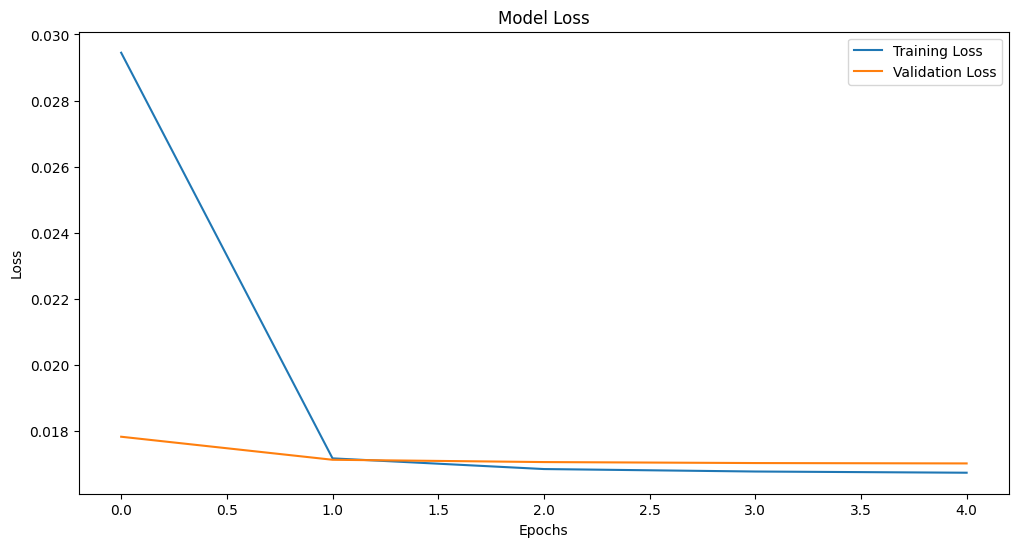

In [133]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [150]:
def get_model_recommendations(user_id, model, anime, anime_id_mapping, inverse_anime_id_mapping, rating, n=10):
    # Map the user_id to the internal user_id used in the model
    mapped_user_id = user_id_mapping.get(user_id, None)
    if mapped_user_id is None:
        raise ValueError(f"User ID {user_id} not found in the user_id_mapping.")

    # Get the list of all anime IDs
    all_anime_ids = np.array(list(anime_id_mapping.values()))

    # Create an array with the user_id repeated for each anime_id
    user_anime_array = np.array([[mapped_user_id, anime_id] for anime_id in all_anime_ids])

    # Predict the ratings for all anime for the given user
    predicted_ratings = model.predict(user_anime_array).flatten()

    # Get the indices of the top n anime with the highest predicted ratings
    top_n_indices = predicted_ratings.argsort()[-n:][::-1]

    # Get the anime IDs for the top n recommendations
    top_n_anime_ids = [inverse_anime_id_mapping[idx] for idx in top_n_indices]

    # Get the top-rated anime for the user
    user_top_rated = rating[rating['user_id'] == mapped_user_id].sort_values(by='rating', ascending=False).head(n)
    user_top_rated_anime_ids = user_top_rated['anime_id'].map(inverse_anime_id_mapping).tolist()

    # Return the top-rated anime and the top n recommended anime
    top_rated_anime = anime[anime['anime_id'].isin(user_top_rated_anime_ids)][['anime_id', 'name', 'genre', 'rating', 'members']]
    recommended_anime = anime[anime['anime_id'].isin(top_n_anime_ids)][['anime_id', 'name', 'genre', 'rating', 'members']]
    
    return top_rated_anime, recommended_anime

In [159]:
# Get a random user ID from the dataset
user_id = random.choice(list(user_id_mapping.keys()))
print(f"Random user ID: {user_id}")

# Get the top-rated anime and recommendations for the random user ID
top_rated, recommendations = get_model_recommendations(user_id, model, anime, anime_id_mapping, inverse_anime_id_mapping, rating, n=5)

Random user ID: 51884
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [160]:
print(f"Top Rated Anime from User {user_id}:")
top_rated

Top Rated Anime from User 51884:


,anime_id,name,genre,rating,members
75,801,Ghost in the Shell: Stand Alone Complex 2nd GIG,"Action, Mecha, Military, Mystery, Police, Sci-...",8.57,113993
185,11843,Danshi Koukousei no Nichijou,"Comedy, School, Shounen, Slice of Life",8.35,258914
191,43,Ghost in the Shell,"Action, Mecha, Police, Psychological, Sci-Fi, ...",8.34,223036
736,534,Slayers,"Adventure, Comedy, Demons, Fantasy, Magic",7.87,73476
1157,4182,Darker than Black: Kuro no Keiyakusha Special,"Comedy, Parody, Sci-Fi",7.65,87609


In [161]:
print(f"Recommended Anime for User {user_id}:")
recommendations

Recommended Anime for User 51884:


,anime_id,name,genre,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25,114262
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16,151266
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",9.11,80679
